In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from datetime import datetime, timedelta
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### ID кустов, для которых нужно выполнить предсказание

In [3]:
kust_ids = [10000430, 145, 10000370, 204]

### ID пациентов с мерцательной аритмией

In [4]:
mercalka = pd.read_csv('Mercalka_people.csv', sep=';')
mercalka_set = set(mercalka.PERSON_INSURANCE_CODE)
len(mercalka_set)

34025

### Привязка пациентов к кустам

In [5]:
patient_kust = pd.read_csv('person_kust_birth.csv', sep=';')
patient_kust.head(10)

,emiasid,date_birth,kust_id
0,16834760,16.11.1969,204
1,26987829,16.12.1987,10000430
2,19043484,16.04.2003,NaN
3,803384666,28.04.1974,145
4,19267466,07.04.1943,10000395
5,19505393,18.10.1975,10000402
6,26074092,19.02.1956,10491203
7,1080178741,07.11.1963,141
8,1635597541,17.08.1957,10000287
9,1739981491,17.10.1946,10146803


#### Отбираем пациентов, привязанных только к выделенным кустам

In [6]:
patient_kust_filtered = patient_kust[patient_kust['kust_id'].isin(kust_ids)]
patient_kust_filtered.head()

,emiasid,date_birth,kust_id
0,16834760,16.11.1969,204
1,26987829,16.12.1987,10000430
3,803384666,28.04.1974,145
26,17693099,10.05.1967,145
38,1411927166,11.05.1986,10000430


#### Общее количество пациентов, привязанных к выделенным кустам

In [7]:
all_patients_flow_by_kust = patient_kust_filtered.groupby('kust_id').aggregate({'emiasid': 'count'})
all_patients_flow_by_kust['TOTAL'] = all_patients_flow_by_kust['emiasid']
del all_patients_flow_by_kust['emiasid']
all_patients_flow_by_kust

,TOTAL
kust_id,
145,249808
204,210943
10000370,199870
10000430,224195


In [8]:
print(patient_kust_filtered.emiasid.count())
print(patient_kust_filtered.emiasid.unique().size)

884816
884815


### Пациенты с их рисками

In [9]:
card_db_patient = pd.read_csv('calculated_score.csv', sep=';')
# card_db_patient[(card_db_patient['AGE_CRITERIUM'] == 1) & (card_db_patient['AGE_CRITERIUM.1'] == 1)]

card_db_patient['SCORE'] = card_db_patient['AGE_CRITERIUM'] + card_db_patient['IS_FEMALE'] + card_db_patient['IS_AG'] +\
    card_db_patient['IS_INSULT'] + card_db_patient['IS_DIABET'] + card_db_patient['IS_NEDOSTAT'] + card_db_patient['IS_SOSUD']
del card_db_patient['AGE_CRITERIUM.1']

card_db_patient = card_db_patient.drop_duplicates('PATIENT_ID')

In [10]:
card_db_mercalka = card_db_patient[card_db_patient['PATIENT_ID'].isin(mercalka_set)]
card_db_mercalka = card_db_mercalka.drop_duplicates('PATIENT_ID')
mercalka_patients_filtered = card_db_mercalka[card_db_mercalka['SCORE'] >= 2]

In [11]:
print(card_db_patient['PATIENT_ID'].unique().size)
print(card_db_patient['PATIENT_ID'].count())

10104161
10104161


In [12]:
card_db_patient_filtered = card_db_patient[card_db_patient['SCORE'] >= 3]
card_db_patient_filtered_PID = card_db_patient_filtered.drop_duplicates('PATIENT_ID')
card_db_patient_filtered_PID_LID = card_db_patient_filtered.drop_duplicates(['PATIENT_ID', 'LPU_ID'])

In [13]:
print(card_db_patient_filtered_PID.PATIENT_ID.unique().size)
print(card_db_patient_filtered_PID_LID.PATIENT_ID.unique().size)

1232393
1232393


In [14]:
print(card_db_patient_filtered_PID.PATIENT_ID.count())
print(card_db_patient_filtered_PID_LID.PATIENT_ID.count())

1232393
1232393


In [15]:
bar_plot_data = card_db_patient.groupby('SCORE').aggregate({'PATIENT_ID': 'count'})
bar_plot_data

,PATIENT_ID
SCORE,
0,3388268
1,4374624
2,1108876
3,775495
4,346072
5,95005
6,14120
7,1471
8,227


In [16]:
means_card = card_db_patient.mean()
means_card

PATIENT_ID       3.335352e+08
LPU_ID           6.421908e+06
AGE_CRITERIUM    2.869938e-01
IS_FEMALE        5.647947e-01
IS_INSULT        4.003301e-03
IS_AG            1.683646e-01
IS_DIABET        3.651436e-02
IS_NEDOSTAT      2.544496e-04
IS_SOSUD         1.536733e-02
SCORE            1.076293e+00
dtype: float64

In [17]:
means_card_alt = means_card[[False, False, True, True, True, True, True, True, True, True, False]].values
my_list = ['AGE_CRITERIUM', 'IS_FEMALE', 'AGE_CRITERIUM.1', 'IS_INSULT', 'IS_AG', 'IS_DIABET', 'IS_NEDOSTAT', 'IS_SOSUD']  

/usr/lib/python2.7/dist-packages/pandas/core/internals.py:222: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 11
  return self.values[slicer]
/usr/lib/python2.7/dist-packages/pandas/core/index.py:1160: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 11
  result = getitem(key)


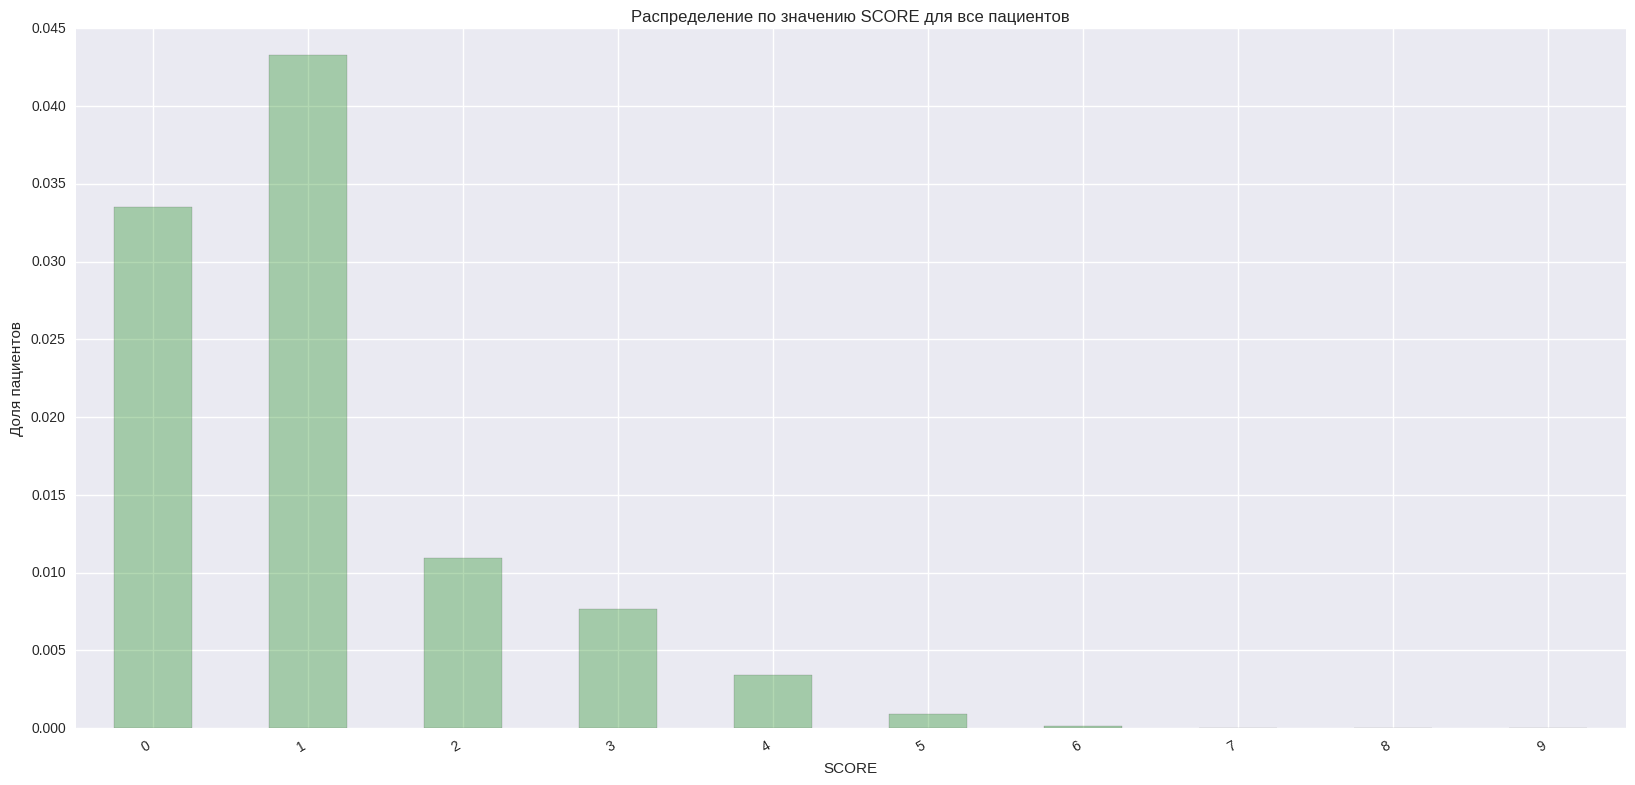

In [20]:
plt.figure(figsize=(20,10))
sum_patients = card_db_patient.size
stars = card_db_patient.SCORE.map(lambda x: int(x))
vc = stars.value_counts().sort_index() / float(sum_patients)
ax = vc.plot(kind='bar', color='g', alpha=0.3, title=u'Распределение по значению SCORE для все пациентов')
ax.set_xlabel('SCORE')
ax.set_ylabel(u'Доля пациентов')
fig = ax.get_figure()
fig.autofmt_xdate()

plt.savefig('./GRAPHS/patient_percent_score_distrib.png')

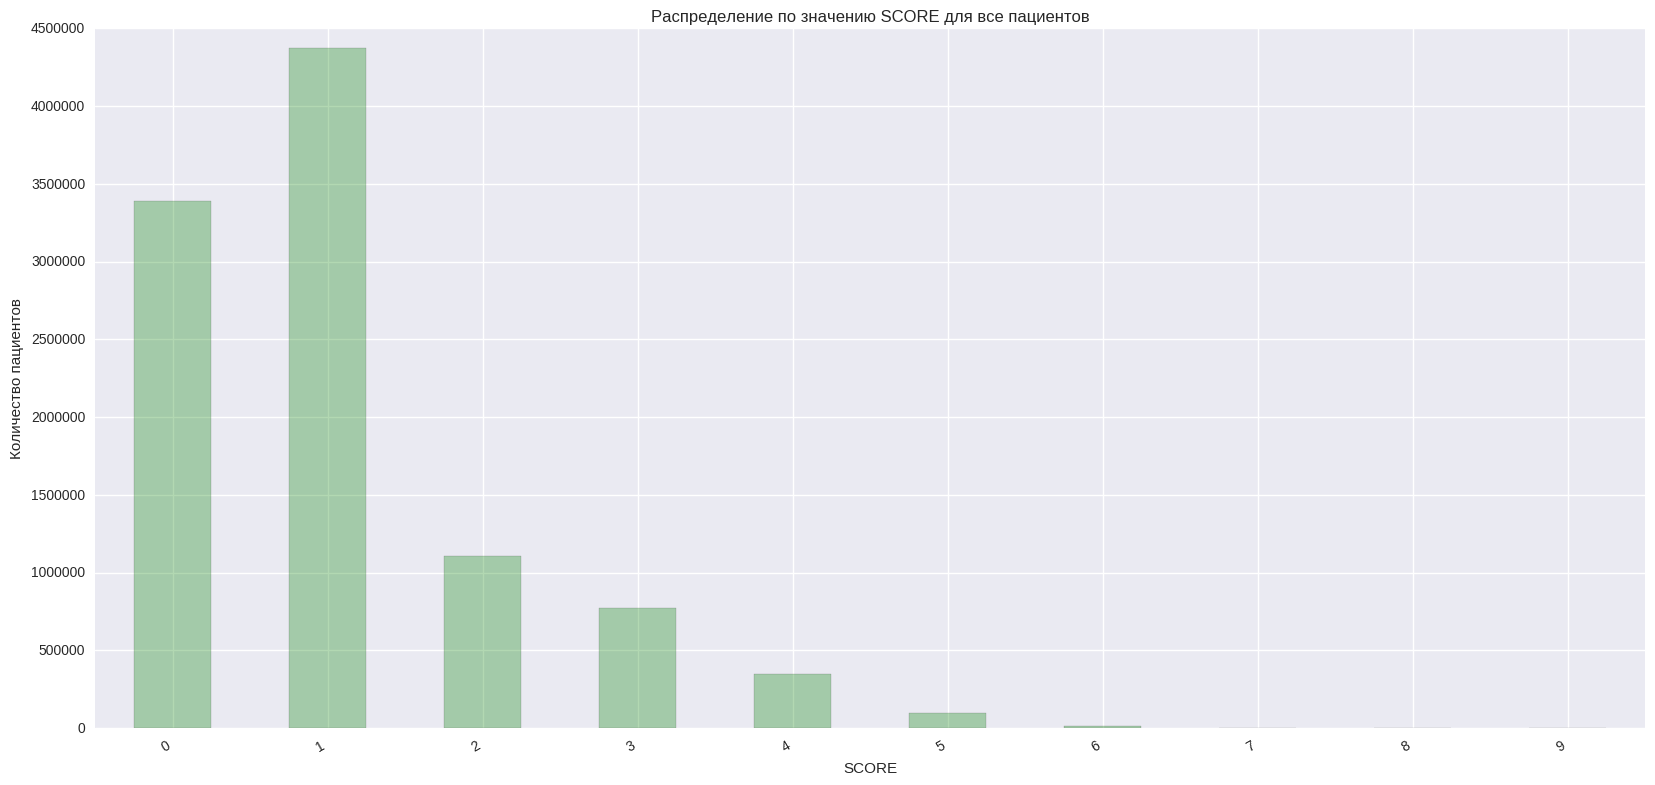

In [22]:
plt.figure(figsize=(20,10))
sum_patients = card_db_patient.size
stars = card_db_patient.SCORE.map(lambda x: int(x))
vc = stars.value_counts().sort_index()
ax = vc.plot(kind='bar', color='g', alpha=0.3, title=u'Распределение по значению SCORE для все пациентов')
ax.set_xlabel('SCORE')
ax.set_ylabel(u'Количество пациентов')
fig = ax.get_figure()
fig.autofmt_xdate()

plt.savefig('./GRAPHS/patient_number_score_distrib.png')

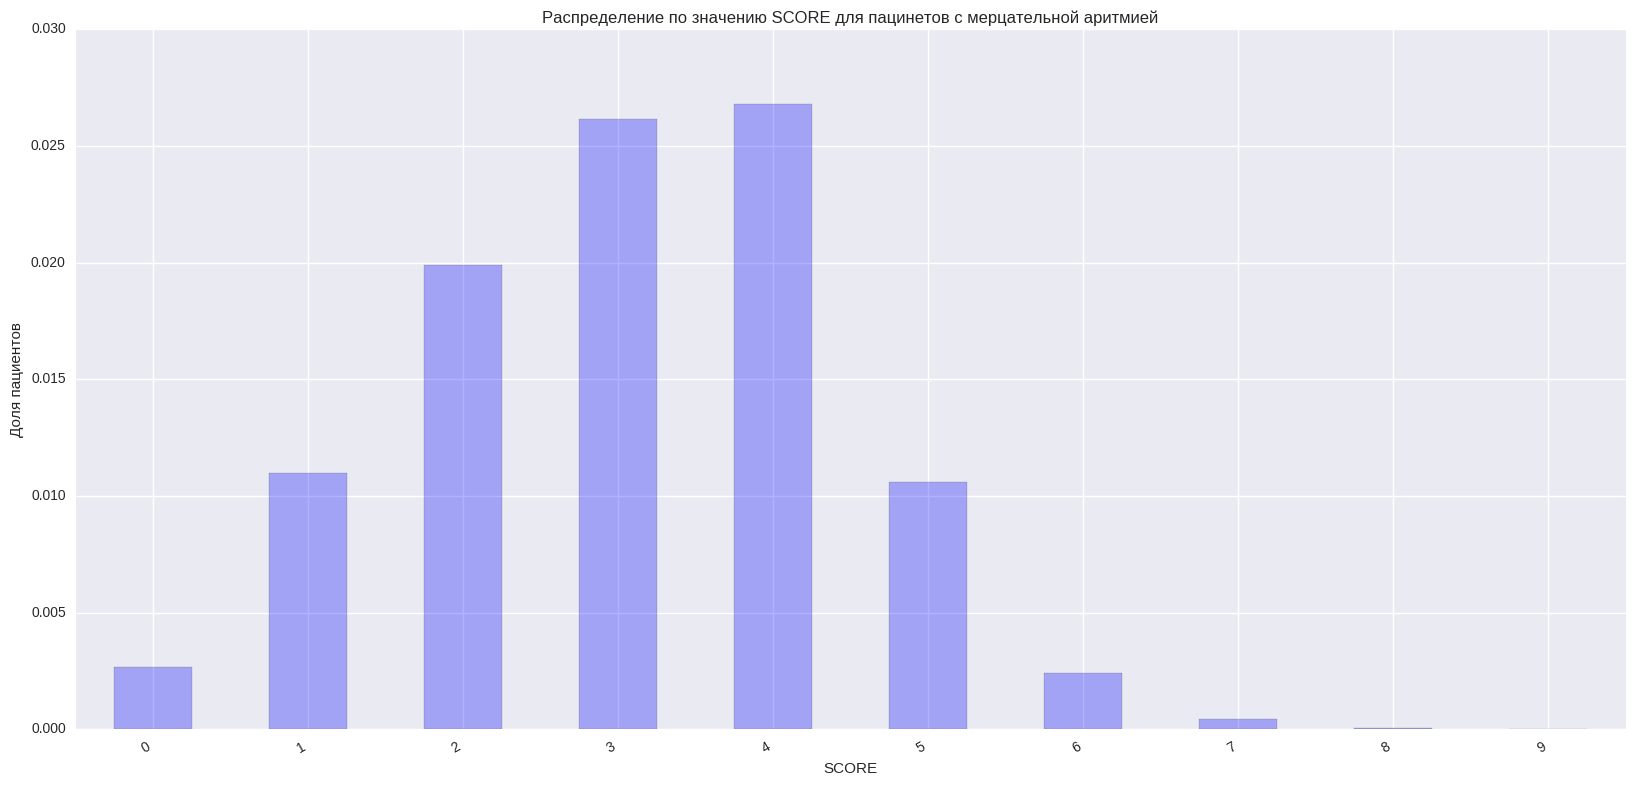

In [24]:
plt.figure(figsize=(20,10))
only_merc =  card_db_patient[card_db_patient['PATIENT_ID'].isin(mercalka_set)]
sum_merc = only_merc.size

stars_merc = only_merc.SCORE.map(lambda x: int(x))
vc_merc = stars_merc.value_counts().sort_index() / float(sum_merc)

ax = vc_merc.plot(kind='bar', color='b', alpha=0.3, title=u'Распределение по значению SCORE для пацинетов с мерцательной аритмией')
ax.set_xlabel('SCORE')
ax.set_ylabel(u'Доля пациентов')
fig = ax.get_figure()
fig.autofmt_xdate()

plt.savefig('./GRAPHS/patient_with_merc_percent_score_distrib.png')

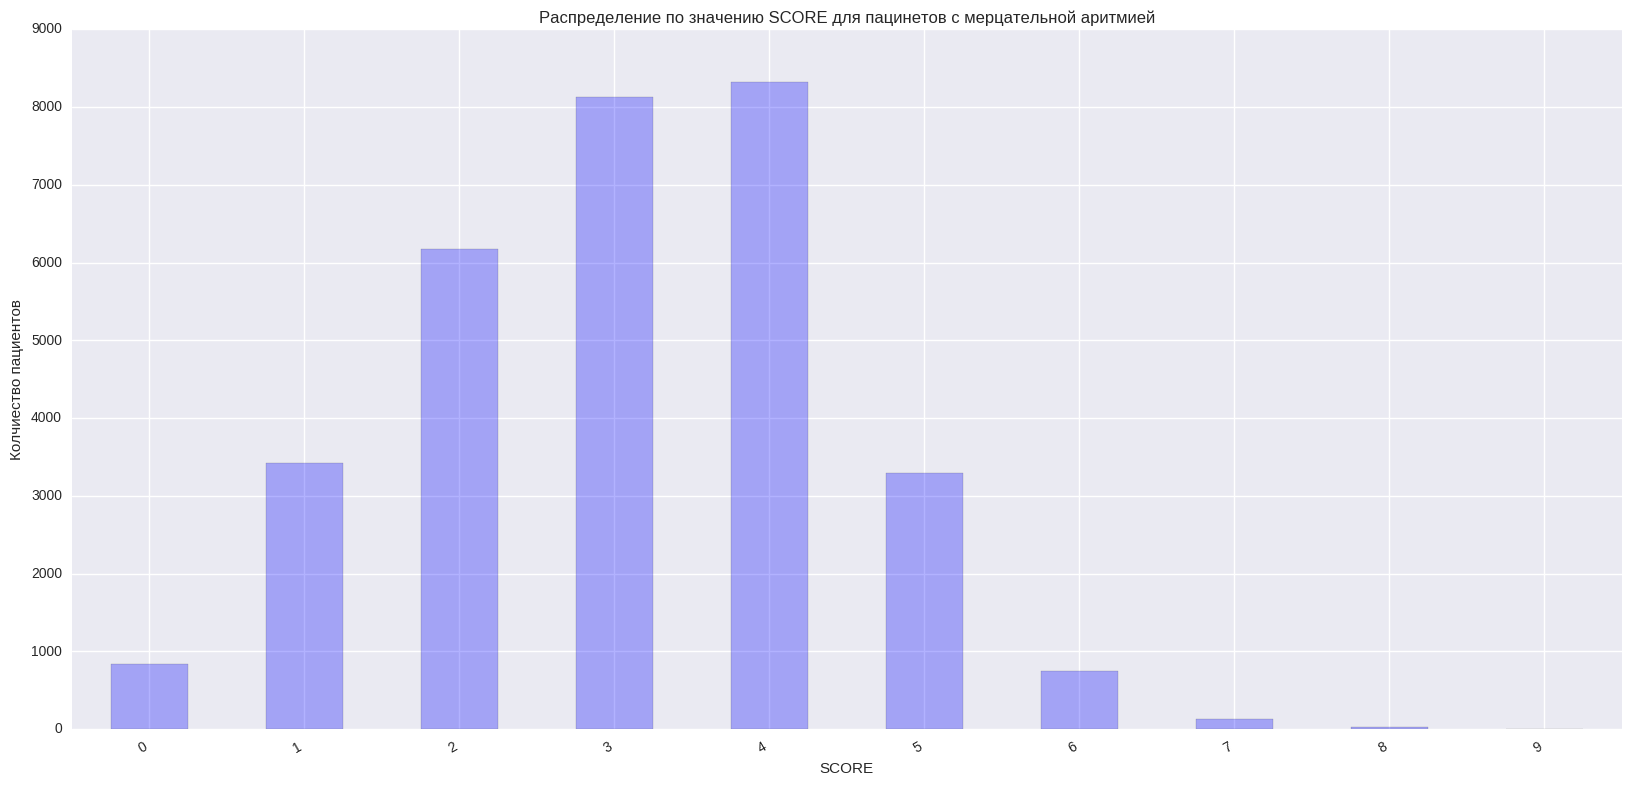

In [25]:
plt.figure(figsize=(20,10))
only_merc =  card_db_patient[card_db_patient['PATIENT_ID'].isin(mercalka_set)]
sum_merc = only_merc.size

stars_merc = only_merc.SCORE.map(lambda x: int(x))
vc_merc = stars_merc.value_counts().sort_index()

ax = vc_merc.plot(kind='bar', color='b', alpha=0.3, title=u'Распределение по значению SCORE для пацинетов с мерцательной аритмией')
ax.set_xlabel('SCORE')
ax.set_ylabel(u'Колчиество пациентов')
fig = ax.get_figure()
fig.autofmt_xdate()

plt.savefig('./GRAPHS/patient_with_merc_number_score_distrib.png')

In [ ]:
print("Суммарное количество людей с мерцабщей аритмией: ", sum_merc)

### Сливаем таблицы

#### Количество пациентов, идущих к супер-кардиологу по кустам

In [26]:
result_merged = pd.merge(patient_kust_filtered, card_db_patient_filtered_PID, left_on='emiasid', \
                         right_on='PATIENT_ID', how='right')
result_merged = result_merged[result_merged['kust_id'].notnull()]
result_merged = result_merged[result_merged['PATIENT_ID'].isin(mercalka_set)]
sum_patients_by_kust = result_merged.groupby('kust_id').aggregate({'emiasid': 'count'})
sum_patients_by_kust['RISK_TOTAL'] = sum_patients_by_kust['emiasid']
del sum_patients_by_kust['emiasid']
sum_patients_by_kust

,RISK_TOTAL
kust_id,
145,605
204,400
10000370,822
10000430,520


In [27]:
risky_flow_portion_by_kust = all_patients_flow_by_kust.copy()
risky_flow_portion_by_kust['RISK_TOTAL'] = sum_patients_by_kust['RISK_TOTAL']
risky_flow_portion_by_kust['RISK_PORTION'] = risky_flow_portion_by_kust['RISK_TOTAL'] / risky_flow_portion_by_kust['TOTAL']
risky_flow_portion_by_kust

,TOTAL,RISK_TOTAL,RISK_PORTION
kust_id,,,
145,249808,605,0.002422
204,210943,400,0.001896
10000370,199870,822,0.004113
10000430,224195,520,0.002319


In [28]:
sum_patients_by_kust['TOTAL_SLOTS_NEEDED'] = sum_patients_by_kust['RISK_TOTAL'] * 4
sum_patients_by_kust

,RISK_TOTAL,TOTAL_SLOTS_NEEDED
kust_id,,
145,605,2420
204,400,1600
10000370,822,3288
10000430,520,2080


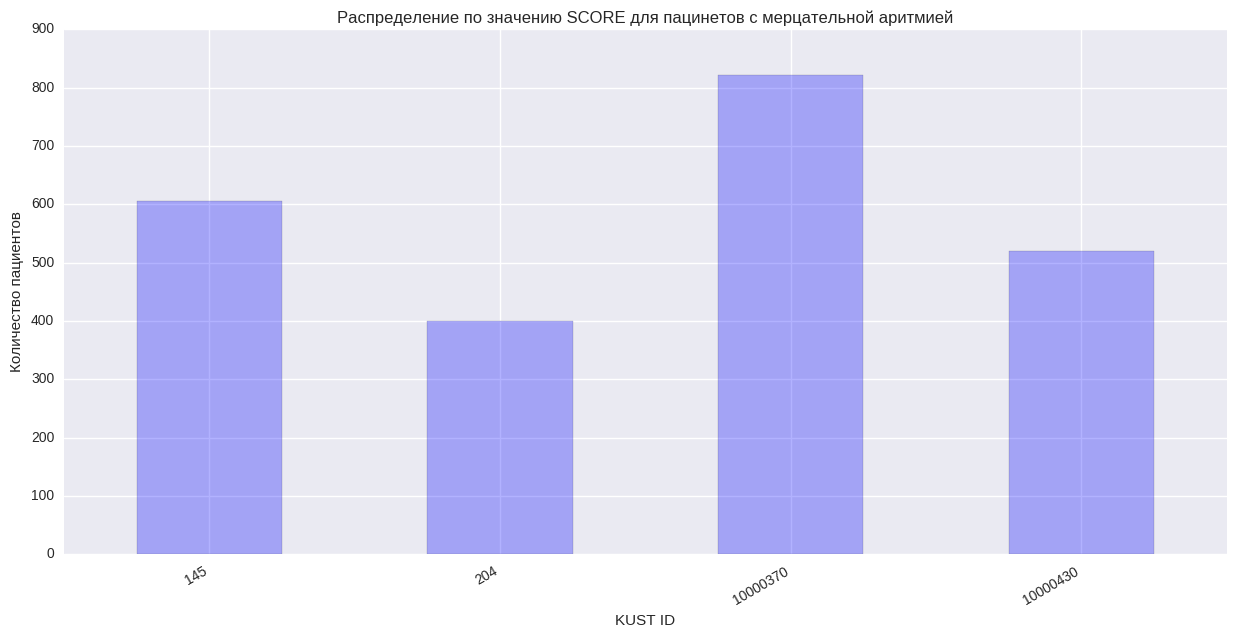

In [30]:
plt.figure(figsize=(15,7.5))
risk_by_kust = sum_patients_by_kust.RISK_TOTAL
risk_by_kust.index = risk_by_kust.index.map(lambda x: int(x))

ax = risk_by_kust.plot(kind='bar', color='b', alpha=0.3, title=u'Распределение по значению SCORE для пацинетов с мерцательной аритмией')
ax.set_xlabel('KUST ID')
ax.set_ylabel(u'Количество пациентов')
fig = ax.get_figure()
fig.autofmt_xdate()

plt.savefig('./GRAPHS/patients_with_merc_over_kusts_distrib.png')